Predicting House Prices with Linear Regression

In [872]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats.mstats import winsorize
import math
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

### My Process
- I first explored the data, identifying data quality issues and assessing the central tendency, spread and distribution of the data.
- This informed the cleaning and tranformation steps I took (replacing location variables with more accurate Google Maps API data, log transforming and winsoring skewed features, defining feature bins, etc).
- From my explorations, I found that the number of baths, number of beds, property sqft, location and house type were all positively correlated with house price.
- I then completed transforming the data for training (target encoding, removing unnecessary columns), then applied the mode.
- My intital results were very strong! 
    - R2 score from training: 0.7283107091882318
    - R2 score from test: 0.7569658634224257
    - MAE: 0.3562472347425393
    - MSE: 0.2371361249409318
- Initially I applied transformations that involved learning from the data (winsoring, replacing NaNs with median values, target encoding, etc.) to my full dataset, before learning that I ought to only apply these to the training set otherwise there will be data leakage (test inadvertently influencing the training, therefore making the trained model look more effective when applied to test dataset). Important learnings!
- I therefore went back and split my training/ test earlier in my process, then applied any transformations involving dataset summary learning (means, medians, etc) only to the training set.
- My final results - still has strong performance!
    - R2 score from training: 0.723513121718732
    - R2 score from test: 0.7033768804333383
    - MAE: 0.3870951053805588
    - MSE: 0.2800336517849796
- Overall I found that property square feet, number of bathrooms and location have the strongest influence on house price. Beds and type have a much weaker influence.

In [919]:
df = pd.read_csv('NY-House-Dataset.csv')
# remove address values, they're not consistent with the coords
df = df.drop(columns=["BROKERTITLE","ADDRESS", "STATE", "MAIN_ADDRESS", "ADMINISTRATIVE_AREA_LEVEL_2", "SUBLOCALITY", "LOCALITY", "STREET_NAME", "LONG_NAME", 'FORMATTED_ADDRESS'])
df

,TYPE,PRICE,BEDS,BATH,PROPERTYSQFT,LATITUDE,LONGITUDE
0,Condo for sale,315000,2,2.000,1400.000,40.761,-73.974
1,Condo for sale,195000000,7,10.000,17545.000,40.766,-73.981
2,House for sale,260000,4,2.000,2015.000,40.542,-74.196
3,Condo for sale,69000,3,1.000,445.000,40.761,-73.975
4,Townhouse for sale,55000000,7,2.374,14175.000,40.767,-73.970
...,...,...,...,...,...,...,...
4796,Co-op for sale,599000,1,1.000,2184.208,40.774,-73.956
4797,Co-op for sale,245000,1,1.000,2184.208,40.733,-73.860
4798,Co-op for sale,1275000,1,1.000,2184.208,40.746,-74.003
4799,Condo for sale,598125,2,1.000,655.000,40.743,-73.873


In [920]:
# initial cleaning

# remove duplicate rows
df = df.drop_duplicates()
# replace default PROPERTYSQFT fill value wtih NaN
df.loc[np.isclose(df['PROPERTYSQFT'], 2184.208, atol=1e-3), 'PROPERTYSQFT'] = np.nan
# log transform SQFT and PRICE for better analysis
df['SQFT_W'] = np.log1p(df['PROPERTYSQFT'])
df['PRICE_W'] = np.log1p(df['PRICE'])
# fix decimal value in bath
df['BATH_clean'] = np.floor(df['BATH'])

/var/folders/ls/qf_80dfs2195wmj6nkccwf8r0000gn/T/ipykernel_1412/3766965361.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['SQFT_W'] = np.log1p(df['PROPERTYSQFT'])
/var/folders/ls/qf_80dfs2195wmj6nkccwf8r0000gn/T/ipykernel_1412/3766965361.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['PRICE_W'] = np.log1p(df['PRICE'])
/var/folders/ls/qf_80dfs2195wmj6nkccwf8r0000gn/T/ipykernel_1412/3766965361.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Tr

In [ ]:
# # store key for for google maps API
# from dotenv import load_dotenv
# import os

# load_dotenv()
# api_key = os.getenv("GOOGLE_API_KEY")

In [ ]:
## producing location categories from coordinates using googlemaps API, save output

# import googlemaps
# import time

# gmaps = googlemaps.Client(key=api_key)

# features = {
#     'route': 'route'
#     , 'neighborhood': 'neighbourhood'
#     , 'political': 'sublocality'
#     , 'administrative_area_level_2': 'administrative_area'
#     }

# coords = df[['LATITUDE', 'LONGITUDE']].drop_duplicates()
# coords

# address_df = pd.DataFrame()

# # for all my coords
# for index, row in coords.iterrows():
#     lat = row['LATITUDE']
#     lon = row['LONGITUDE']

#     # call API, assign result
#     reverse_geocode_result = gmaps.reverse_geocode((lat,lon))
#     components = reverse_geocode_result[0]["address_components"]

#      # extract desired values from API
#     new_row = {
#     out_key: next(
#         (comp["long_name"] for comp in components if in_key in comp["types"])
#         , None
#     )
#     for in_key, out_key in features.items()
#     }

#     # add coords for joining later
#     new_row.update({"lat": lat, 'long': lon}) 

#     # append to df
#     address_df = pd.concat([address_df, pd.DataFrame([new_row])], ignore_index=True)

#     # cap 10 requests/ second
#     time.sleep(0.1)

# # once table is complete, export to CSV
# address_df.to_csv('correct_addresses.csv', index=False)
# print(address_df)

In [ ]:
# # join API location values to main dataframe, save output
# addresses = pd.read_csv("correct_addresses.csv")

# df["LATITUDE"] = df["LATITUDE"].round(3)
# df["LONGITUDE"] = df["LONGITUDE"].round(3)

# addresses = addresses.drop(columns=["Unnamed: 0", "route", "neighbourhood"]).drop_duplicates()
# addresses["LATITUDE"] = addresses["lat"].round(3)
# addresses["LONGITUDE"] = addresses["long"].round(3)

# addresses_dedup = (
#     addresses
#     .sort_values(["LATITUDE", "LONGITUDE"])
#     .drop_duplicates(subset=["LATITUDE", "LONGITUDE"], keep="first")
# )

# merged = df.merge(addresses_dedup, on=["LATITUDE", "LONGITUDE"], how="inner")

# df = merged
# df = df.drop(columns=['lat','long']).drop_duplicates()
# df.to_csv('final_house_prices_v2_cleaning_only.csv')

/var/folders/ls/qf_80dfs2195wmj6nkccwf8r0000gn/T/ipykernel_1412/2154505973.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["LATITUDE"] = df["LATITUDE"].round(3)
/var/folders/ls/qf_80dfs2195wmj6nkccwf8r0000gn/T/ipykernel_1412/2154505973.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["LONGITUDE"] = df["LONGITUDE"].round(3)


In [1015]:
df = pd.read_csv('final_house_prices_v2_cleaning_only.csv').drop(columns=['Unnamed: 0','LATITUDE','LONGITUDE','PRICE'])
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)

In [1016]:
# additional cleaning

# replace with group medians by house type for a more accurate fill value
group_medians = train_df.groupby("TYPE")["SQFT_W"].median()
train_df["SQFT_W"] = train_df["SQFT_W"].fillna(train_df["TYPE"].map(group_medians))
train_df["SQFT_W"] = train_df["SQFT_W"].fillna(train_df["SQFT_W"].median())
test_df["SQFT_W"] = test_df["SQFT_W"].fillna(test_df["TYPE"].map(group_medians))
test_df["SQFT_W"] = test_df["SQFT_W"].fillna(test_df["SQFT_W"].median())

# winsorise
def winsor_limits (df, cols, lower=0.01, upper=0.99):
    return {c: tuple(df[c].quantile([lower,upper]).values) for c in cols}

limits = winsor_limits(train_df, cols=["SQFT_W", "PRICE_W", "BEDS", "BATH_clean"], lower=0.01, upper=0.99)

def apply_winsor(df, limits):
    out = df.copy()
    for c, (lo,hi) in limits.items():
        out[c] = out[c].clip(lo,hi)
    return out

train_df = apply_winsor(train_df, limits)
test_df = apply_winsor(test_df, limits)


In [1017]:
# Determine outlier cutoff point for number of beds and baths
print(f"BEDS cutoff: {train_df['BEDS'].quantile(0.975)}")
print(f"BATH_clean cutoff: {train_df['BATH_clean'].quantile(0.975)}")

BEDS cutoff: 8.0
BATH_clean cutoff: 6.0


In [1018]:
train_df["TYPE"].value_counts()

TYPE
Co-op for sale                1100
House for sale                 760
Condo for sale                 686
Multi-family home for sale     511
Townhouse for sale             230
Pending                        179
Contingent                      67
Land for sale                   37
For sale                        15
Foreclosure                     13
Condop for sale                  4
Coming Soon                      1
Mobile house for sale            1
Name: count, dtype: int64

In [1019]:
# clean features

# group uncommon house type values as Other
counts = train_df["TYPE"].value_counts()
rare = counts[counts < 50].index
train_df['TYPE_grouped'] = train_df['TYPE'].replace(rare, 'Other')
test_df['TYPE_grouped'] = test_df['TYPE'].replace(rare, 'Other')

# clip number of beds and baths by 0.975 outlier cutoff point
train_df['BATH_clean'] = train_df['BATH_clean'].clip(upper=6)
test_df['BATH_clean'] = test_df['BATH_clean'].clip(upper=6)
train_df['BEDS_clean'] = train_df['BEDS'].clip(upper=8)
test_df['BEDS_clean']  = test_df['BEDS'].clip(upper=8)

# group uncommon sublocality value as Other
top = train_df["sublocality"].value_counts().nlargest(25).index
train_df["sublocality_grouped"] = train_df["sublocality"].where(train_df["sublocality"].isin(top), "Other")
test_df["sublocality_grouped"] = test_df["sublocality"].where(test_df["sublocality"].isin(top), "Other")

In [1020]:
# measure coefficient of variance (CV), used this to identify features that required windsor, log transformation, etc. 
# which I applied above
n_df = train_df.select_dtypes(include='number')
cv = n_df.std() / n_df.mean()
print (cv)

BEDS           0.564
BATH           0.635
PROPERTYSQFT   1.183
SQFT_W         0.082
PRICE_W        0.073
BATH_clean     0.577
BEDS_clean     0.553
dtype: float64


In [1021]:
# measure skew and kurtosis
sk_df = df.select_dtypes(include='number')
skew_lvl = sk_df.skew()
kurt_lvl = sk_df.kurt()
print (skew_lvl)
print (kurt_lvl)

BEDS            1.352
BATH            2.286
PROPERTYSQFT   11.742
SQFT_W          0.615
PRICE_W         0.847
BATH_clean      2.330
dtype: float64
BEDS             3.262
BATH            10.495
PROPERTYSQFT   226.508
SQFT_W           0.931
PRICE_W          2.450
BATH_clean      10.609
dtype: float64


<Axes: xlabel='BATH_clean'>

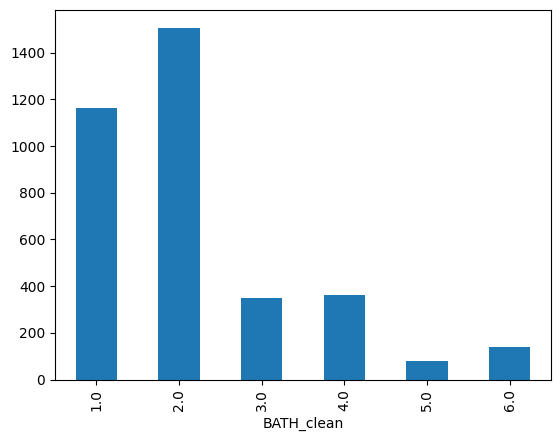

In [1022]:
# distribution of num. of baths
train_df['BATH_clean'].value_counts().sort_index().plot(kind='bar')

<Axes: >

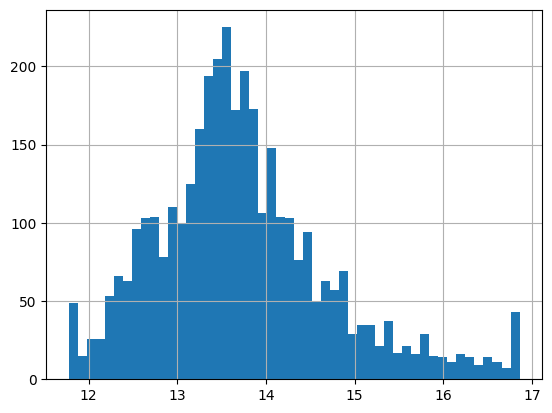

In [996]:
# distribution of dependent variable PRICE_W (house price), required windsoring 
train_df['PRICE_W'].hist(bins=50)

<Axes: >

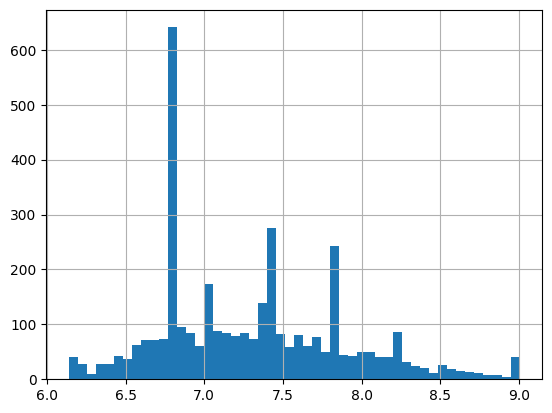

In [997]:
# SQFT distribution
train_df['SQFT_W'].hist(bins=50)

<Axes: xlabel='TYPE_grouped'>

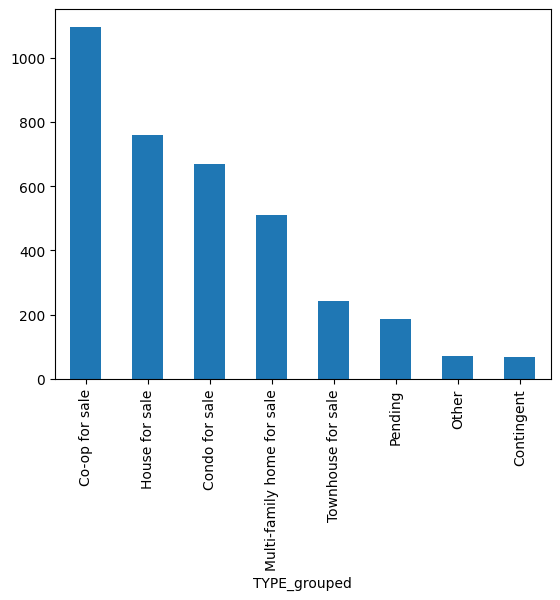

In [998]:
# house type distribution
train_df.groupby('TYPE_grouped')['PRICE_W'].count().sort_values(ascending=False).plot(kind='bar')

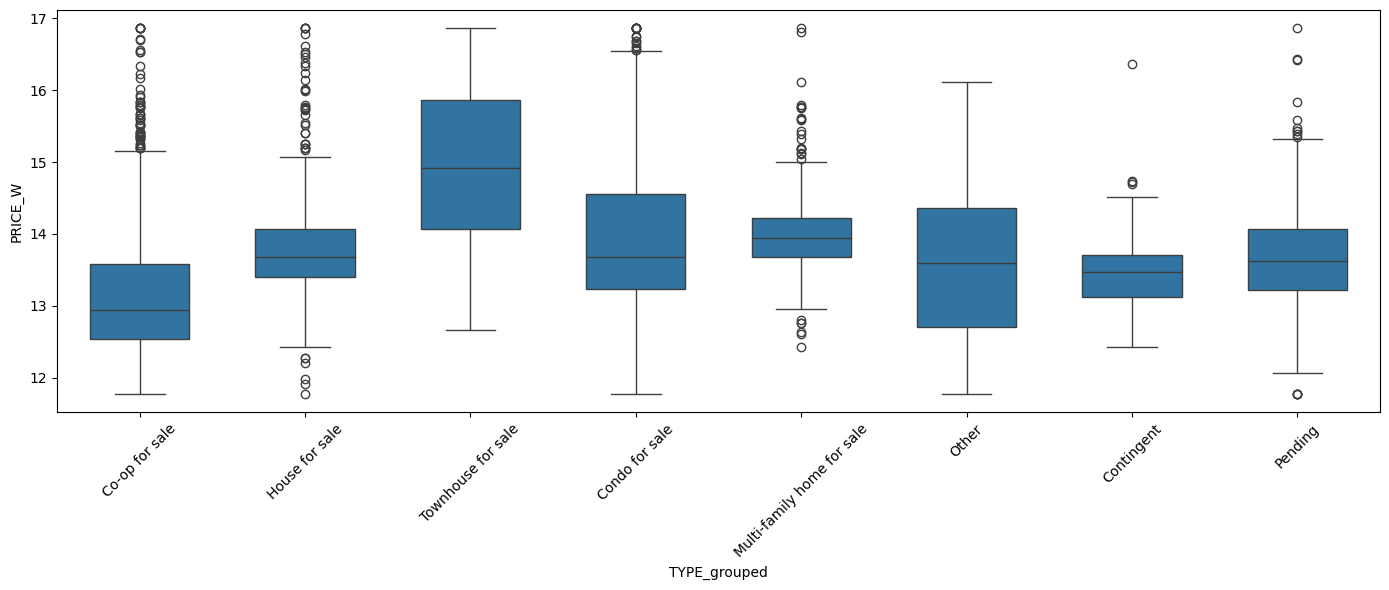

In [999]:
# value spread of house types
plt.figure(figsize=(14,6))
sns.boxplot(x='TYPE_grouped', y='PRICE_W', data=train_df, width=0.6)
plt.xticks(rotation=45)
plt.tight_layout()

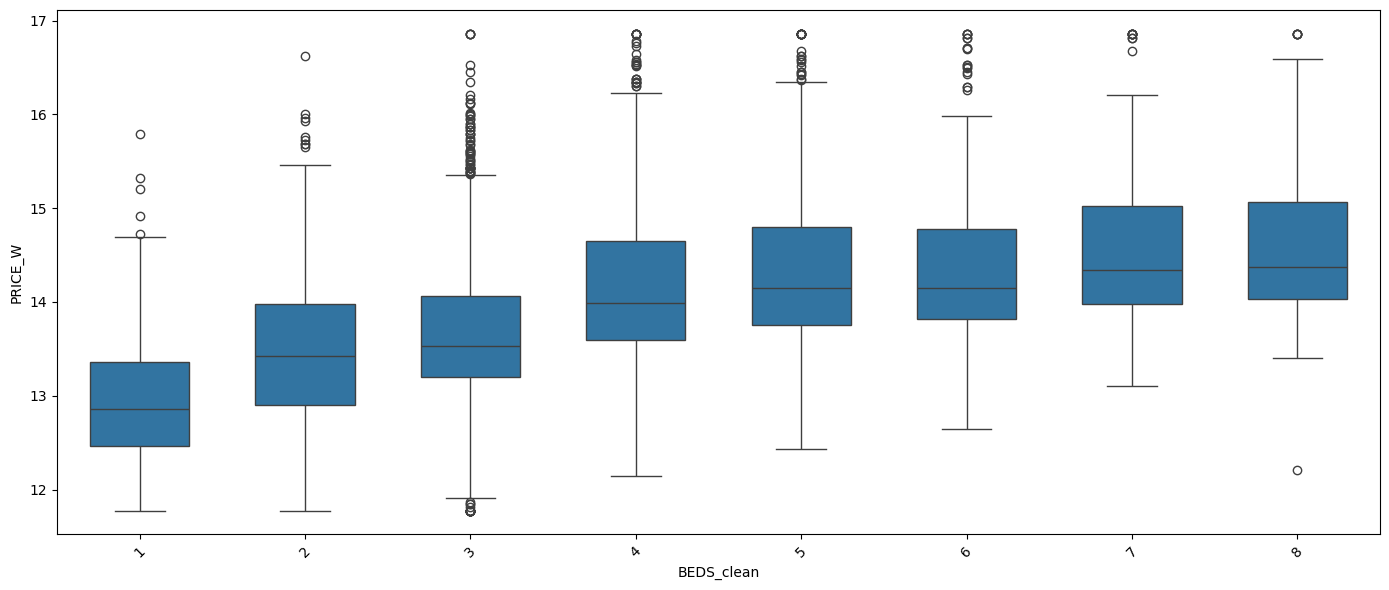

In [1000]:
# value spread of number of beds

plt.figure(figsize=(14,6))
sns.boxplot(x='BEDS_clean', y='PRICE_W', data=train_df, width=0.6)
plt.xticks(rotation=45)
plt.tight_layout()

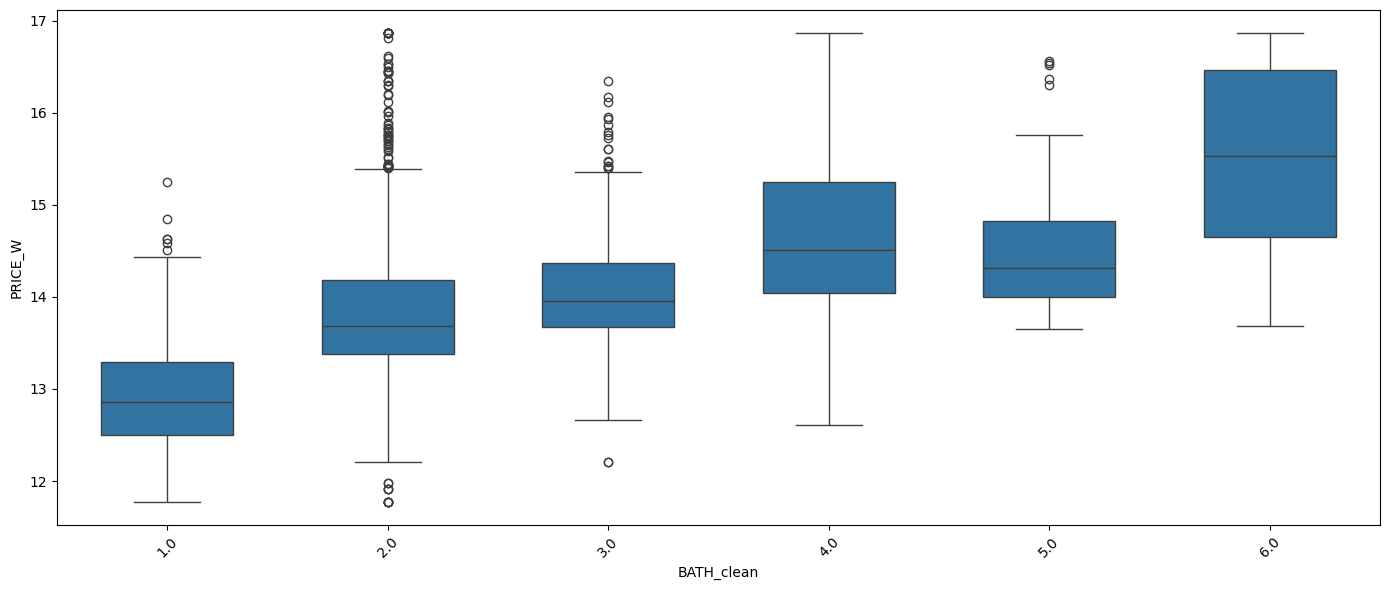

In [1001]:
# value spread of number of baths

plt.figure(figsize=(14,6))
sns.boxplot(x='BATH_clean', y='PRICE_W', data=train_df, width=0.6)
plt.xticks(rotation=45)
plt.tight_layout()

In [1023]:
# ANOVA
from scipy.stats import f_oneway
groups = [g['PRICE_W'].values for _, g in train_df.groupby('TYPE_grouped')]
f_stat, p_val = f_oneway(*groups)
print(math.floor(f_stat), p_val)

149 9.226046241543746e-195


In [1024]:
# Kruskal-Wallis statistic

from scipy.stats import kruskal
groups = [g['PRICE_W'] for _, g in train_df.groupby('TYPE_grouped')]
stat, p = kruskal(*groups)
print(stat, p)

867.782763501374 4.342574361748125e-183


In [1025]:
# posthoc dunn
import scikit_posthocs as sp
sp.posthoc_dunn(train_df, val_col='PRICE_W', group_col='TYPE_grouped', p_adjust='bonferroni')

,Co-op for sale,Condo for sale,Contingent,House for sale,Multi-family home for sale,Other,Pending,Townhouse for sale
Co-op for sale,1.000,0.000,0.368,0.000,0.000,0.000,0.000,0.000
Condo for sale,0.000,1.000,0.001,1.000,0.000,0.512,0.437,0.000
Contingent,0.368,0.001,1.000,0.011,0.000,1.000,0.683,0.000
House for sale,0.000,1.000,0.011,1.000,0.000,1.000,1.000,0.000
Multi-family home for sale,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000
Other,0.000,0.512,1.000,1.000,0.000,1.000,1.000,0.000
Pending,0.000,0.437,0.683,1.000,0.000,1.000,1.000,0.000
Townhouse for sale,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000


In [1026]:
# Normality per group
from scipy.stats import shapiro, levene
for k, g in train_df.groupby('TYPE_grouped'):
    print(k, shapiro(g['PRICE_W']).pvalue)

# Equal variance test
levene(*[g['PRICE_W'].values for _, g in train_df.groupby('TYPE_grouped')])

Co-op for sale 1.9838781983014467e-25
Condo for sale 9.407233165425446e-16
Contingent 8.868133319131037e-07
House for sale 3.913547105825698e-23
Multi-family home for sale 1.2188540457109153e-16
Other 0.35654396630908447
Pending 4.516392468811373e-06
Townhouse for sale 1.174361655015091e-05


LeveneResult(statistic=np.float64(40.46369526684026), pvalue=np.float64(3.7914376023243164e-55))

In [1027]:
# target encoding categorical features
to_encode = ['TYPE_grouped','BATH_clean','BEDS_clean', 'sublocality_grouped', "administrative_area"]
for c in to_encode:
    mean_price = train_df.groupby(c)['PRICE_W'].mean()
    col_name = c.replace("_grouped", "").replace("_clean", "")
    train_df[f'{col_name}_enc'] = train_df[c].map(mean_price)
    test_df[f'{col_name}_enc'] = test_df[c].map(mean_price)


# fill administrative area NaN with median value
admin_area_median = train_df["administrative_area_enc"].median()
train_df["administrative_area_enc"] = train_df["administrative_area_enc"].fillna(admin_area_median)
test_df["administrative_area_enc"] = test_df["administrative_area_enc"].fillna(admin_area_median)

In [1036]:
# calculate correlation between house price and number of baths
print(train_df[['PRICE_W', 'BATH_enc']].corr(method='spearman'))

# calculate correlation between house price and number of beds
print(train_df[['PRICE_W', 'BEDS_enc']].corr(method='spearman'))

# calculate correlation between house price and sublocality
print(train_df[['sublocality_enc','PRICE_W']].corr(method='spearman'))

# calculate correlation between house price and administrative area
print(train_df[['administrative_area_enc','PRICE_W']].corr(method='spearman'))

          PRICE_W  BATH_enc
PRICE_W     1.000     0.704
BATH_enc    0.704     1.000
          PRICE_W  BEDS_enc
PRICE_W     1.000     0.534
BEDS_enc    0.534     1.000
                 sublocality_enc  PRICE_W
sublocality_enc            1.000    0.418
PRICE_W                    0.418    1.000
                         administrative_area_enc  PRICE_W
administrative_area_enc                    1.000    0.397
PRICE_W                                    0.397    1.000


In [1033]:
features = ['SQFT_W', 'TYPE_enc', 'BATH_enc', 'BEDS_enc', 'sublocality_enc', 'administrative_area_enc']
target = 'PRICE_W'

X_train = train_df[features]
X_test = test_df[features]
y_train = train_df[target]
y_test = test_df[target]

# fit scaler on train
scaler = StandardScaler().fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled  = scaler.transform(X_test)

# fit model
lr = LinearRegression().fit(X_train_scaled, y_train)

In [ ]:
# RESULTS!!

# Original before fixing train / test

# R2 score from training: 0.7283107091882318
# R2 score from test: 0.7569658634224257
# MAE: 0.3562472347425393
# MSE: 0.2371361249409318
# Coefficient: [0.33266925 0.07143837 0.33844425 0.00042017 0.25842805 0.21441719]

# Final results

# R2 score from training: 0.723513121718732
# R2 score from test: 0.7033768804333383
# MAE: 0.3870951053805588
# MSE: 0.2800336517849796
# Coefficients: [0.33847784 0.08738895 0.35221572 0.01943063 0.18563445 0.26437854]

# Property size, bathrooms, and location have strong influence on price
# beds and type have weaker impact

print(f'R2 score from training: {lr.score(X_train_scaled, y_train)}')
print(f'R2 score from test: {lr.score(X_test_scaled, y_test)}')

y_pred = lr.predict(X_test_scaled)
print(f'MAE: {mean_absolute_error(y_test, y_pred)}')
print(f'MSE: {mean_squared_error(y_test, y_pred)}')

print(f'Coefficients: {lr.coef_}')

R2 score from training: 0.723513121718732
R2 score from test: 0.7033768804333383
MAE: 0.3870951053805588
MSE: 0.2800336517849796
Coefficients: [0.33847784 0.08738895 0.35221572 0.01943063 0.18563445 0.26437854]
